# PyTorch Implementation

## Model Definition

In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import datasets, transforms

import matplotlib as mpl
import matplotlib.pyplot as plt
import random

In [ ]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, padding, mask_type='B', rgb = False, **kwargs):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, padding=padding, **kwargs)
        assert mask_type in {'A', 'B', 'V'}, "mask_type must be either 'A', 'B' or 'V'"
        
        self.padding = padding

        self.register_buffer('mask', torch.ones_like(self.weight.data))
        out_channels, in_channels, h, w = self.weight.size()

        # Default is to set center everything to zero, then adjust based on mask_type, rgb
        # center x and y really only works if h,w are uneven...
        yc, xc = h // 2, w // 2 


        if mask_type == 'V':
            # We define the vertical stack
            # All elements are set to 1, except for the rows below yc which are set to 0
            self.mask[:, :, yc+1:, :] = 0
        else: 
            # We define the horizontal stack
            # Everything is set to 0 except the center row up to but not including the center column which we set to 1
            self.mask[:, :, :, :] = 0
            self.mask[:, :, yc, :xc] = 1    

            # If mask_type == 'B' we are allowed to see the current context (i.e. we set center position to 1)
            if mask_type == 'A':
                self.mask[:, :, :yc, :] = 1
            elif rgb == False and mask_type == 'B':
                self.mask[:, :, :, :] = 0
                self.mask[:, :, yc, :xc+1] = 1  

            # rgb logic:
            if rgb == True:
                # if we are not able to evenly divide the input channels, then red gets an extra
                # if there are multiple residual channels, then green gets the second one (only 2 possible)
                in_div = in_channels // 3
                in_res = in_channels % 3
                in_r = in_div + (in_res >= 1)
                in_g = in_r + in_div + (in_res == 2)

                
                # Now we do the same for the output channels
                out_div = out_channels // 3
                out_res = out_channels % 3
                out_r = out_div + (out_res >= 1)
                out_g = out_r + out_div + (out_res == 2)


                if mask_type == 'A':
                    # If mask_type == 'A'
                    # red is only allowed to see the previous context, 
                    # green is allowed to see the previous context plus the red values
                    # blue is allowed to see the previous context plus the red and green values
                    self.mask[out_r:out_g, :in_r, yc, xc] = 1
                    self.mask[out_g:, :in_g, yc, xc] = 1
                if mask_type == 'B':
                    # If mask_type == 'B'
                    # red is allowed to see the previous context plus the red values
                    # green is allowed to see the previous context plus the red and green values
                    # blue is allowed to see the previous context plus the red, green and blue values
                    self.mask[:out_r, :in_r, yc, xc] = 1
                    self.mask[out_r:out_g, :in_g, yc, xc] = 1
                    self.mask[out_g:, :, yc, xc] = 1


    def forward(self, x):
        masked_weight = self.weight * self.mask

        return F.conv2d(x, masked_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


In [ ]:
class PixelBlock(nn.Module):
    def __init__(self, channels, rgb):
        super(PixelBlock, self).__init__()

        
        if rgb:
            assert channels % 3 == 0, "Number of channels must be divisible by 3"  # Not sure if this is needed...

        self.v_stack = MaskedConv2d(channels, 2*channels, kernel_size=3, padding=(2,1), mask_type='V', rgb=rgb)
        self.h_stack = MaskedConv2d(channels, 2*channels, kernel_size=3, padding=1, mask_type='B', rgb=rgb)   

        self.v_to_h_conv = MaskedConv2d(2*channels, 2*channels, kernel_size=1, padding=0, mask_type='B', rgb=rgb)
        self.h_to_h_conv = MaskedConv2d(channels, channels, kernel_size=1, padding=0, mask_type='B', rgb=rgb)
        self.v_to_v_conv = nn.Conv2d(channels, 2*channels, kernel_size=1)

        self.res_conv = MaskedConv2d(channels, 2*channels, kernel_size=1, padding=0, mask_type='B', rgb=rgb)


        self.emb_conv_h_tanh = nn.Conv2d(channels, channels, kernel_size=1)
        self.emb_conv_h_sigmoid = nn.Conv2d(channels, channels, kernel_size=1)

        self.emb_conv_v_tanh = nn.Conv2d(channels, channels, kernel_size=1)
        self.emb_conv_v_sigmoid = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, v, h, label_embedding):

        #### Vertical stack: ####

        v_out = F.relu(self.v_stack(v))

        # Output: (N, C, H, W) dvs. cropping på H
        v_res = F.relu(self.v_to_v_conv(v))
        v_to_v = v_out[:,:,1:-1,:] + v_res


        # We split 2*C channels into C C channels 
        v_0 = v_to_v[:, 0::2, :, :]
        v_1 = v_to_v[:, 1::2, :, :]

        v = F.tanh(v_0 + F.relu(self.emb_conv_v_tanh(label_embedding))) * F.sigmoid(v_1 + F.relu(self.emb_conv_v_sigmoid(label_embedding)))

        #### Horizontal stack: ####

        # We shift output of vertical stack up, to not access future information
        v_to_h = v_out[:,:,:-2,:] 
        v_to_h = F.relu(self.v_to_h_conv(v_to_h))

        h_out = F.relu(self.h_stack(h))
        h_out = h_out + v_to_h

        # Similar as v_0, v_1
        h_0 = h_out[:, 0::2, :, :]
        h_1 = h_out[:, 1::2, :, :]

        h_act = F.tanh(h_0 + F.relu(self.emb_conv_h_tanh(label_embedding))) * F.sigmoid(h_1 + F.relu(self.emb_conv_h_sigmoid(label_embedding)))
        h_out = F.relu(self.h_to_h_conv(h_act))
        h = h_out + h 

        # We also want a skip connection to be used before final output of entire model
        res = F.relu(self.res_conv(h_act))  

        return v, h, res


    
class PixelBlockList(nn.Module):
    def __init__(self, channels, num_blocks, rgb):
        super(PixelBlockList, self).__init__()

        self.blocks = nn.ModuleList([
            PixelBlock(channels, rgb=rgb) for _ in range(num_blocks)
        ])
      
    def forward(self, x, label_embedding):
        v = x
        h = x
        skip = 0
        for block in self.blocks:
            v, h, res = block(v, h, label_embedding) 
            skip += res
        return skip
    
class PixelCNN(nn.Module):
    def __init__(self, channels, num_blocks, levels, num_classes, rgb):

        super(PixelCNN, self).__init__()
        self.levels = levels
        self.rgb = rgb
        if self.rgb:
            self.rgb_channels = 3
        else: 
            self.rgb_channels = 1

        # Although kernel_size = 1, we still need to use MaskedConv2d in case we are handling RGB
        self.conv0 = MaskedConv2d(self.rgb_channels, channels, kernel_size=3, padding=1, mask_type='A', rgb=rgb)
        self.pixel_blocks = PixelBlockList(channels, num_blocks, rgb)
        self.conv1 = MaskedConv2d(2*channels, channels, kernel_size=1, padding=0, mask_type='B', rgb=rgb)     
        self.conv2 = MaskedConv2d(channels, self.levels*self.rgb_channels, kernel_size=1, padding=0, mask_type='B', rgb=rgb)

        self.label_embedding = nn.Embedding(num_classes, channels)

        self.emb_conv = nn.Conv2d(channels, 2*channels, kernel_size=1)

    def forward(self, x, class_label):
        label_emb = self.label_embedding(class_label)
        label_emb = label_emb[:, :, None, None]

        emb_transform = F.relu(self.emb_conv(label_emb))

        x = F.relu(self.conv0(x))
        x = F.relu(self.pixel_blocks(x, label_emb) + emb_transform)
        x = F.relu(self.conv1(x))
        x = self.conv2(x)

        return x

## Training on MNIST

In [ ]:
# We clamp the pixel values to make training more simple at the cost of image quality
levels = 9

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.floor(x * levels).clamp(0, levels-1).to(torch.float))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
rgb = False 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PixelCNN(32*3, 7, levels=levels, num_classes=10, rgb=rgb).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-07)
criterion = nn.CrossEntropyLoss(reduction='sum')

In [ ]:
current_lr = optimizer.param_groups[0]['lr']

epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_pixels = 0
    for imgs, labels in train_loader:
        imgs = imgs.to(device) 

        labels = labels.to(device)
        targets = imgs.to(torch.int64)
        outputs = model(imgs, labels)  

        if model.rgb:
            out_r = outputs[:, 0:levels, :, :]
            out_g = outputs[:, levels:2*levels, :, :]
            out_b = outputs[:, 2*levels:3*levels, :, :]

            loss_r = criterion(out_r, targets[:, 0, :, :])
            loss_g = criterion(out_g, targets[:, 1, :, :])
            loss_b = criterion(out_b, targets[:, 2, :, :])

            loss = loss_r + loss_g + loss_b
        else:
            loss = criterion(outputs, targets.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_pixels += targets.numel()

    avg_pixel_loss = total_loss/total_pixels
    
    model.eval()
    total_loss_val = 0
    total_pixels = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device) 

            labels = labels.to(device)
            targets = imgs.to(torch.int64)
            outputs = model(imgs, labels) 

            if model.rgb:
                out_r = outputs[:, 0:levels, :, :]
                out_g = outputs[:, levels:2*levels, :, :]
                out_b = outputs[:, 2*levels:3*levels, :, :]

                loss_r = criterion(out_r, targets[:, 0, :, :])
                loss_g = criterion(out_g, targets[:, 1, :, :])
                loss_b = criterion(out_b, targets[:, 2, :, :])

                loss = loss_r + loss_g + loss_b
            else:
                loss = criterion(outputs, targets.squeeze())



            total_loss_val += loss.item()
            total_pixels += targets.numel()
    avg_pixel_loss_val = total_loss_val/total_pixels

    print(f"Epoch {epoch+1}/{epochs}, avg_pixel_loss: {avg_pixel_loss:.4f}, avg_pixel_loss_val: {avg_pixel_loss_val:.4f}, Learning_Rate: {current_lr}")

    scheduler.step(avg_pixel_loss_val)
    current_lr = scheduler.get_last_lr()[0]

Epoch 1/30, avg_pixel_loss: 0.2863, avg_pixel_loss_val: 0.2536, Learning_Rate: 0.001
Epoch 2/30, avg_pixel_loss: 0.2457, avg_pixel_loss_val: 0.2404, Learning_Rate: 0.001
Epoch 3/30, avg_pixel_loss: 0.2375, avg_pixel_loss_val: 0.2353, Learning_Rate: 0.001
Epoch 4/30, avg_pixel_loss: 0.2332, avg_pixel_loss_val: 0.2325, Learning_Rate: 0.001
Epoch 5/30, avg_pixel_loss: 0.2301, avg_pixel_loss_val: 0.2297, Learning_Rate: 0.001
Epoch 6/30, avg_pixel_loss: 0.2277, avg_pixel_loss_val: 0.2268, Learning_Rate: 0.001
Epoch 7/30, avg_pixel_loss: 0.2256, avg_pixel_loss_val: 0.2249, Learning_Rate: 0.001
Epoch 8/30, avg_pixel_loss: 0.2236, avg_pixel_loss_val: 0.2228, Learning_Rate: 0.001
Epoch 9/30, avg_pixel_loss: 0.2225, avg_pixel_loss_val: 0.2223, Learning_Rate: 0.001
Epoch 10/30, avg_pixel_loss: 0.2215, avg_pixel_loss_val: 0.2217, Learning_Rate: 0.001
Epoch 11/30, avg_pixel_loss: 0.2208, avg_pixel_loss_val: 0.2209, Learning_Rate: 0.001
Epoch 12/30, avg_pixel_loss: 0.2201, avg_pixel_loss_val: 0.2207

## Sampling MNIST

In [7]:
def sample(model, image_size, label, device='cpu', num_samples=16, levels=levels, rgb=True):
    model.eval()
    H, W = image_size

    channels = 3 if rgb else 1
    
    samples = torch.zeros(num_samples, channels, H, W).to(device)  # Start with zeros
    
    if isinstance(label, int):
        labels = torch.full((num_samples,), label, dtype=torch.long, device=device)
    elif isinstance(label, torch.Tensor):
        labels = label.to(device)
    else:
        raise ValueError("label must be an int or a LongTensor")

    with torch.no_grad():
        for i in range(H):
            for j in range(W): 
                for c in range(channels):
                    output = model(samples, labels)
                    out_c_logits = output[:, c*levels:(c+1)*levels, i, j]
                    probs = F.softmax(out_c_logits, dim=1)  # Convert to probabilities
                    sampled = torch.multinomial(probs, num_samples=1).squeeze(-1)
                    samples[:, c, i, j] = sampled  # Set sampled pixel

    return samples  # Shape: [B, channels, H, W], values in [0, levels-1]

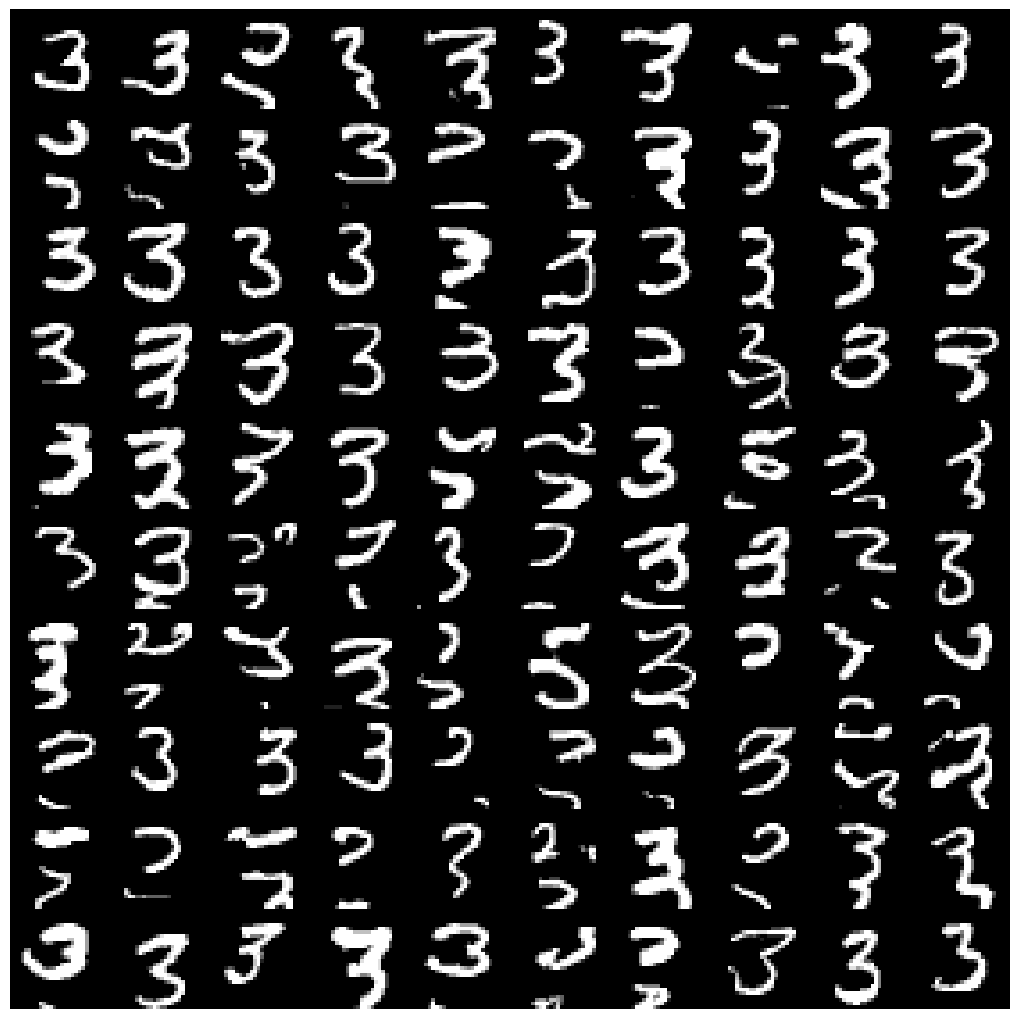

In [ ]:
generated = sample(model.to(device), image_size=(28,28), label=3, device=device, num_samples=100, rgb=rgb)

generated = generated.cpu().numpy()  # Move to CPU and convert to NumPy array for plotting
generated = generated / (levels - 1)

# Plot in a 10x10 grid
fig, axs = plt.subplots(10, 10, figsize=(10, 10))
if generated.shape[1] == 3:
    for i, ax in enumerate(axs.flat):
        img = generated[i]  
        
        
        img_rgb = img.transpose(1, 2, 0)  
        
        
        ax.imshow(img_rgb)
        ax.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(0, 0)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()
else: 
    for i, ax in enumerate(axs.flat):
        img = generated[i]  
        img_gray = img.squeeze()
        
        ax.imshow(img_gray, cmap='gray')
        ax.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(0, 0)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()

We get some pretty nice results. It is clear from the generated images that we are conditioning on label 3.

## Training on CIFAR

In [ ]:
levels = 9

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.floor(x * levels).clamp(0, levels-1).to(torch.float))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
rgb = True 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PixelCNN(32*3, 7, levels=levels, num_classes=10, rgb=rgb).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-07)
criterion = nn.CrossEntropyLoss(reduction='sum')

In [13]:
current_lr = optimizer.param_groups[0]['lr']

epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_pixels = 0
    for imgs, labels in train_loader:
        imgs = imgs.to(device) 

        labels = labels.to(device)
        targets = imgs.to(torch.int64)
        outputs = model(imgs, labels)  

        if model.rgb:
            out_r = outputs[:, 0:levels, :, :]
            out_g = outputs[:, levels:2*levels, :, :]
            out_b = outputs[:, 2*levels:3*levels, :, :]

            loss_r = criterion(out_r, targets[:, 0, :, :])
            loss_g = criterion(out_g, targets[:, 1, :, :])
            loss_b = criterion(out_b, targets[:, 2, :, :])

            loss = loss_r + loss_g + loss_b
        else:
            loss = criterion(outputs, targets.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_pixels += targets.numel()

    avg_pixel_loss = total_loss/total_pixels
    
    model.eval()
    total_loss_val = 0
    total_pixels = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device) 

            labels = labels.to(device)
            targets = imgs.to(torch.int64)
            outputs = model(imgs, labels) 

            if model.rgb:
                out_r = outputs[:, 0:levels, :, :]
                out_g = outputs[:, levels:2*levels, :, :]
                out_b = outputs[:, 2*levels:3*levels, :, :]

                loss_r = criterion(out_r, targets[:, 0, :, :])
                loss_g = criterion(out_g, targets[:, 1, :, :])
                loss_b = criterion(out_b, targets[:, 2, :, :])

                loss = loss_r + loss_g + loss_b
            else:
                loss = criterion(outputs, targets.squeeze())



            total_loss_val += loss.item()
            total_pixels += targets.numel()
    avg_pixel_loss_val = total_loss_val/total_pixels

    print(f"Epoch {epoch+1}/{epochs}, avg_pixel_loss: {avg_pixel_loss:.4f}, avg_pixel_loss_val: {avg_pixel_loss_val:.4f}, Learning_Rate: {current_lr}")

    scheduler.step(avg_pixel_loss_val)
    current_lr = scheduler.get_last_lr()[0]

Epoch 1/30, avg_pixel_loss: 0.8080, avg_pixel_loss_val: 0.7517, Learning_Rate: 0.001
Epoch 2/30, avg_pixel_loss: 0.5986, avg_pixel_loss_val: 0.5803, Learning_Rate: 0.001
Epoch 3/30, avg_pixel_loss: 0.5715, avg_pixel_loss_val: 0.5625, Learning_Rate: 0.001
Epoch 4/30, avg_pixel_loss: 0.5594, avg_pixel_loss_val: 0.5579, Learning_Rate: 0.001
Epoch 5/30, avg_pixel_loss: 0.5523, avg_pixel_loss_val: 0.5457, Learning_Rate: 0.001
Epoch 6/30, avg_pixel_loss: 0.5451, avg_pixel_loss_val: 0.5444, Learning_Rate: 0.001
Epoch 7/30, avg_pixel_loss: 0.5410, avg_pixel_loss_val: 0.5479, Learning_Rate: 0.001
Epoch 8/30, avg_pixel_loss: 0.5372, avg_pixel_loss_val: 0.5430, Learning_Rate: 0.001
Epoch 9/30, avg_pixel_loss: 0.5339, avg_pixel_loss_val: 0.5344, Learning_Rate: 0.001
Epoch 10/30, avg_pixel_loss: 0.5306, avg_pixel_loss_val: 0.5300, Learning_Rate: 0.001
Epoch 11/30, avg_pixel_loss: 0.5300, avg_pixel_loss_val: 0.5261, Learning_Rate: 0.001
Epoch 12/30, avg_pixel_loss: 0.5248, avg_pixel_loss_val: 0.5263

In [22]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

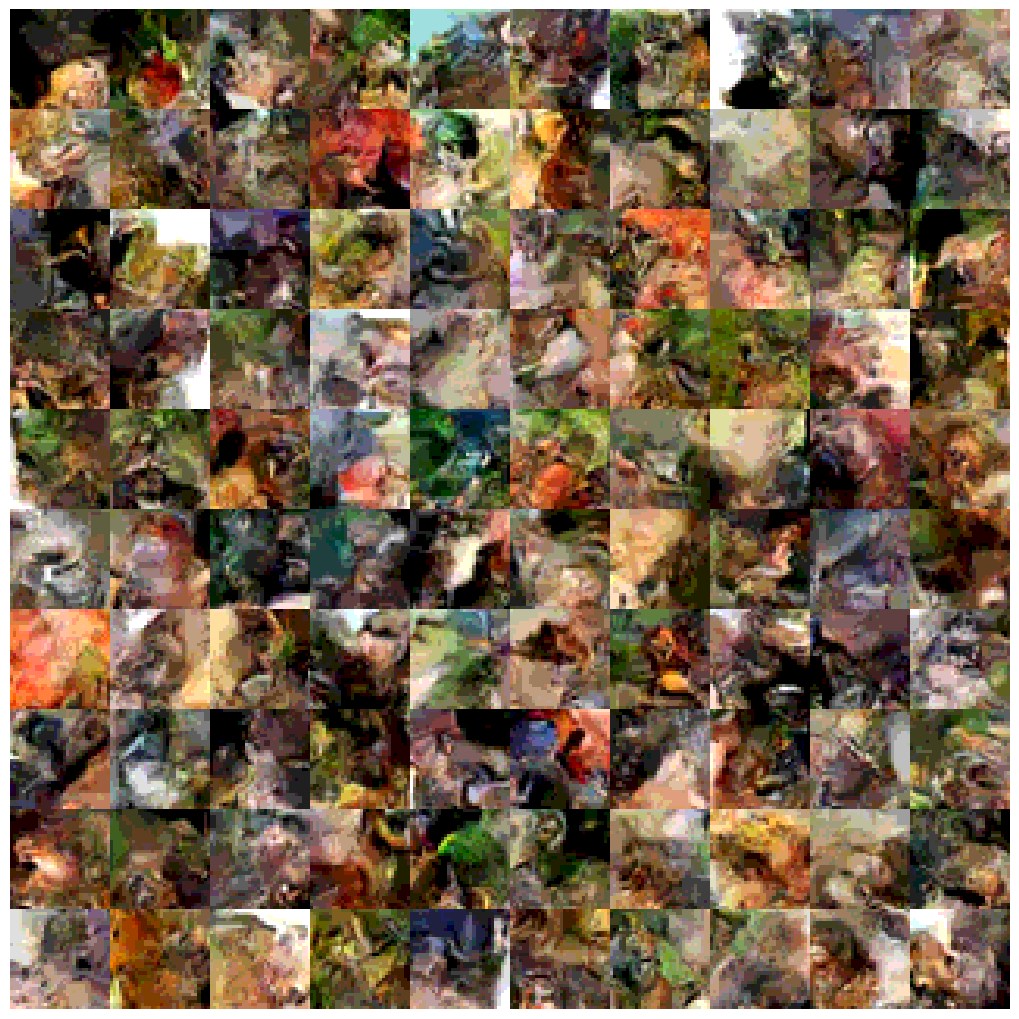

In [25]:
# label = 6 should correspond to 'frog'

generated = sample(model.to(device), image_size=(32,32), label=6, device=device, num_samples=100, rgb=rgb)

generated = generated.cpu().numpy()  # Move to CPU and convert to NumPy array for plotting
generated = generated / (levels - 1)

# Plot in a 10x10 grid
fig, axs = plt.subplots(10, 10, figsize=(10, 10))
if generated.shape[1] == 3:
    for i, ax in enumerate(axs.flat):
        img = generated[i]  
        
        
        img_rgb = img.transpose(1, 2, 0)  
        
        
        ax.imshow(img_rgb)
        ax.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(0, 0)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()
else: 
    for i, ax in enumerate(axs.flat):
        img = generated[i]  
        img_gray = img.squeeze()
        
        ax.imshow(img_gray, cmap='gray')
        ax.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(0, 0)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()

It is difficult to tell that the generated images above are conditioned specifically on frogs. However, the presence of green tones suggests that the model is at least partially capturing the color distribution of the class. In general, the generated images don't look as if there is some error in our model implementation. We could likely improve on these results by training a larger model, but we stop here due to time constraints.